# GPU Unleashed: Training Reinforcement Learning Agents with Stable Baselines3 on AMD GPU in Gymnasium Environment

**Author:** Douglas Jia, AI Software Solutions \
**Read time:** 10 minutes\
**Last edited:** xx Jan 2024

This blog will delve into the fundamentals of deep reinforcement learning, guiding you through a practical code example that utilizes an AMD GPU to train a Deep Q-Network (DQN) policy within the Gymnasium environment.

## Introduction

### What is reinforcement learning

Reinforcement learning (RL) is a powerful paradigm in machine learning that revolves around the idea of training intelligent agents to make sequential decisions in dynamic environments. Unlike supervised learning, RL agents learn by interacting with an environment, receiving feedback in the form of rewards or penalties based on the actions they take. The fundamental goal of reinforcement learning is for an agent to learn a policy that represents a strategy that maps states to actions in a way that increases the expected reward over time. The learning process involves the agent exploring the environment, making decisions, observing outcomes, and adjusting its strategy based on the received feedback. This iterative cycle of exploration and exploitation allows RL agents to adapt to changing conditions, learn complex decision-making strategies, and, ultimately, optimize their behavior to achieve long-term objectives. Reinforcement learning finds applications in diverse fields, from robotics and game playing to finance and autonomous systems, where agents can autonomously learn and improve their decision-making abilities in complex and dynamic scenarios.

### How does deep learning come into play

In reinforcement learning, deep learning can address the challenges posed by high-dimensional state spaces and enhance function (i.e., state-action value function or policy) approximation. This is particularly crucial in environments with extensive or continuous state spaces, especially when represented by high-dimensional inputs like images. Neural networks, with their interconnected layers of neurons, excel at automatically learning hierarchical representations from raw data. This ability is vital for capturing intricate patterns necessary for decision-making in RL tasks. Deep RL algorithms, such as DQN or policy gradient methods, leverage the power of deep learning to generalize across diverse states, making them well-suited for real-world applications where traditional methods may struggle. The synergy of deep learning and RL enables the training of agents capable of mastering complex tasks in dynamic and diverse environments. Specifically, the input to a deep reinforcement learning system is typically observations from the environment, and the goal is to learn a policy (represented by a neural network) that outputs actions to maximize cumulative rewards over time. The learning process involves optimizing the parameters of the policy based on the feedback received from the environment in the form of rewards.

If you want to dive deeper into the knowledge of deep RL, you can visit this [Deep Reinforcement Learning Course](https://huggingface.co/learn/deep-rl-course/unit0/introduction) hosted by Hugging Face.

### What are Gymnasium and Stable Baselines3

Imagine a virtual playground for AI athletes – that's Gymnasium! [Gymnasium](https://gymnasium.farama.org/) is a maintained fork of OpenAI’s Gym library. This open-source toolkit provides virtual environments, from balancing Cartpole robots to navigating Lunar Lander challenges. It's where your AI agents get to flex their muscles and learn by doing.

But training these athletes takes a coach, one with experience and finesse. That's where [Stable Baselines3](https://stable-baselines3.readthedocs.io/en/master/) comes in. This package empowers you with ready-made reinforcement learning algorithms, from DQN to Policy Gradients. Think of it as a toolbox full of proven training techniques, ready to unleash your AI agent's full potential within the Gym's diverse arenas.

In essence, Gymnasium serves as the environment for the application of deep learning algorithms offered by Stable Baselines3 to learn and optimize policies. To enhance the efficiency of the training process, we harnessed the power of AMD GPUs, and in the code example below, we'll demonstrate the extent of acceleration achievable through this approach.

## Code example on training a car racing agent

### Implementation environment 

We implemented the code example with an AMD GPU on [AMD Accelerator Cloud](https://aac.amd.com/) with Pytorch 2.0.1 and ROCm 5.7.0. Refer to this [ROCm documentation page](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/reference/system-requirements.html) for a list of supported OS and hardware.

To start the example, we need to install the python packages needed to run this code example.

In [2]:
%%capture

!pip install stable-baselines3 gymnasium[all]

### Gymnasium environment

We will use the `CarRacing-v2` environment with discrete action spaces in Gymnasium. For more detailed information about this environment, please refer to [the official documentation](https://gymnasium.farama.org/environments/box2d/car_racing/). The Car Racing environment in Gymnasium is a simulation designed for training reinforcement learning agents in the context of car racing. The primary goal of this environment is for the agent to navigate a track efficiently, considering factors such as speed, steering, and braking, while maximizing cumulative rewards. The state space in CarRacing includes visual observations represented as RGB images, providing the agent with information about the current state of the environment. The discrete action space consists of 5 actions: `0: do nothing`, `1: steer left`, `2: steer right`, `3: gas`, and `4: brake`, allowing the agent to control the car's movements. The reward function, based on official documentation, is "-0.1 every frame and +1000/N for every track tile visited, where N is the total number of tiles visited in the track. For example, if you have finished in 732 frames, your reward is 1000 - 0.1*732 = 926.8 points." and "The car can also go outside the playfield - that is, far off the track, in which case it will receive -100 reward and die.".

Thus, the challenge lies in learning a policy that enables the agent to maneuver the car effectively through the track, avoiding obstacles, and achieving optimal performance based on the reward structure defined in the environment.

With the code block below, you can output the action space, observation space and other environment specifications.


In [15]:
import gymnasium as gym
env = gym.make("CarRacing-v2", domain_randomize=True, continuous=False)

print("Action Space:", env.action_space)

# Note, in the output Observation Space Box(0, 255, (96, 96, 3), uint8),
# 0 and 255 represent the lower and upper limit of the numbers in that
# (96, 96, 3) array.
print("Observation Space: ", env.observation_space)

print("Env Spec: ", env.spec)

Action Space: Discrete(5)
Observation Space:  Box(0, 255, (96, 96, 3), uint8)
Env Spec:  EnvSpec(id='CarRacing-v2', entry_point='gymnasium.envs.box2d.car_racing:CarRacing', reward_threshold=900, nondeterministic=False, max_episode_steps=1000, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={'domain_randomize': True, 'continuous': False}, namespace=None, name='CarRacing', version=2, additional_wrappers=(), vector_entry_point=None)


Next, we will show you how the Gymnasium environment works via an agent that makes action decisions randomly. The agent will make 10 sequential actions. After implementing each action, the environment will return the next observation (or the state), the reward for taking that action, if the environment has terminated or truncated (by satisfying the predefined conditions) due to the latest action and information from the environment about the step, i.e. metrics, debug info. Based on the output, you can see that most of the random actions lead to negative rewards.

In [26]:
import gymnasium as gym

# First, we create our environment called CarRacing-v2.
env = gym.make("CarRacing-v2", domain_randomize=True, continuous=False)

# Then we reset this environment
observation, info = env.reset()

for _ in range(10):
    # Take a random action from the action space.
    action = env.action_space.sample()

    # Do this action in the environment and get
    # next_state, reward, terminated, truncated and info
    observation, reward, terminated, truncated, info = env.step(action)
    print(f"Action taken: {action}, reward: {reward}.")

    # If the game is terminated (in our case we land, crashed) or truncated (timeout),
    # reset the environment.
    if terminated or truncated:
        # Reset the environment
        print("Environment is reset")
        observation, info = env.reset()

env.close()

Action taken: 0, reward: 7.1463768115942035.
Action taken: 4, reward: -0.09999999999999964.
Action taken: 1, reward: -0.09999999999999964.
Action taken: 0, reward: -0.09999999999999964.
Action taken: 4, reward: -0.09999999999999964.
Action taken: 1, reward: -0.09999999999999964.
Action taken: 4, reward: -0.09999999999999964.
Action taken: 4, reward: -0.09999999999999964.
Action taken: 2, reward: -0.09999999999999964.
Action taken: 0, reward: -0.09999999999999964.


### Training a smart agent with stable baselines3

It is evident that relying on random actions won't lead to success in this car racing game. Our objective is to train a deep neural network by learning knowledge from the environment, enabling it to make action choices that maximize the cumulative reward.

In this specific environment, we will use DQN with convolutional neural network (CNN) to train the smart agent. The DQN is trained by minimizing the temporal difference error between the predicted Q-values and the target Q-values. The CNN architecture is used to process the raw pixel input (game frames or observations) and extract relevant features that are useful for making predictions. 

In [1]:
import gymnasium as gym
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import EvalCallback

In [2]:
from typing import Callable

# In our experiments, using a linear schedule that gradually decreases the
# learning rate achieved better performance than using a fixed learning rate.
def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func

To understand what each metric means in the output of the cell below, you can visit [this page](https://stable-baselines3.readthedocs.io/en/master/common/logger.html). Please be advised that we've condensed the output to save page space. Nonetheless, you should still be able to observe the agent's gradual acquisition of environmental knowledge and its corresponding increase in rewards in the displayed output below.

In [ ]:
import os

env = gym.make("CarRacing-v2", domain_randomize=True, continuous=False)

# Set seed for reproducibility.
env.reset(seed=1234)
env.action_space.seed(123)

# Instantiate the agent and specify the directory for Tensorboard log.
# With Tensorboard log, we can monitor the model training progress.
model = DQN('CnnPolicy', env, verbose=1, device="cuda", learning_rate=linear_schedule(0.0001), tensorboard_log="./dqn_carrace_tensorboard_lr0001_1e7/")
# Specify the directory to save the best model.
dnq_path = os.path.join('./Saved_Models/dqn_best_model_lr0001_1e7')

# EvalCallback evaluates periodically the performance of an agent, using
# a separate test environment. It will save the best model if 
# best_model_save_path folder is specified.
eval_env = model.get_env()
eval_callback = EvalCallback(eval_env=eval_env, best_model_save_path=dnq_path,
                             n_eval_episodes=50,
                             eval_freq=100000,verbose=1,
                             deterministic=True, render=False)

# Train the agent.
model.learn(total_timesteps=10000000,callback=eval_callback)

# Specify the path to save the final model.
final_path = os.path.join('./Saved_Models/dqn_final_model_lr0001_1e7')
model.save(final_path)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to ./dqn_carrace_tensorboard_lr0001_1e7/DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | -52.4    |
|    exploration_rate | 0.996    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 167      |
|    time_elapsed     | 23       |
|    total_timesteps  | 4000     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | -52.7    |
|    exploration_rate | 0.992    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 167      |
|    time_elapsed     | 47       |
|    total_timesteps  | 8000     |
----------------------------------
----------------------------------
| rol

After loading the TensorBoard file (refer to [this tutorial](https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks) for guidance), take a look at the reward under eval/mean_reward. You'll notice that the reward converges to around 870 after completing 3.5 million total training timesteps. This is a noteworthy achievement, especially considering that the theoretical maximum reward is below 1000.  Please note that the two lines (dark line and light line) are actually based on the same set of data. Dark line is the smoothed version of the light line (based on raw data) and can better reflect the general trend.

<img src='../images/eval_reward.png' />

You can find our saved best model `best_model.zip` and TensorBoard file in the `src` folder. With the model file, you can load it and use it to play the game in a way that gives you the highest cumulative reward.

### Visualize the car race

Now, let's dive into the exciting part! We can visually compare the performance of the trained agent with that of randomly selecting actions in a cartoon setting. As depicted in the cartoons, when actions are randomly chosen, the car moves slowly and consistently incurs negative rewards (cumulative rewards were shown in the bottom left corner of the cartoon). However, with the trained agent, the car accelerates quickly and adeptly navigates through various road conditions. Pretty amazing, isn't it?

In [13]:
%%capture
!sudo apt update -y && sudo apt upgrade -y
!sudo apt install ffmpeg -y

In [14]:
import gymnasium as gym
from matplotlib import rcParams
from matplotlib import pyplot as plt, animation
from IPython.display import HTML
from stable_baselines3 import DQN
rcParams['animation.embed_limit'] = 2**128

# Define some utility functions for generating and saving the cartoons.
def create_anim(frames, dpi, fps):
    plt.figure(figsize=(frames[0].shape[1] / dpi, frames[0].shape[0] / dpi), dpi=dpi)
    patch = plt.imshow(frames[0])
    def setup():
        plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
    anim = animation.FuncAnimation(plt.gcf(), animate, init_func=setup, frames=len(frames), interval=fps)
    return anim

def display_anim(frames, dpi=72, fps=60):
    anim = create_anim(frames, dpi, fps)
    return anim.to_jshtml()

def save_anim(frames, filename, dpi=72, fps=50):
    anim = create_anim(frames, dpi, fps)
    anim.save(filename)


In [4]:
env = gym.make("CarRacing-v2", domain_randomize=True, continuous=False, render_mode='rgb_array')

# Generate observations of one episode with random actions.
frames = []
episodes = 1

for episode in range(1, episodes+1):
    state = env.reset()
    terminated = truncated = False
    score = 0
    
    while not (terminated or truncated):
        frames.append(env.render())
        # Note: here we are randomly sampling an action.
        action = env.action_space.sample()
        observation, reward, terminated, truncated, info = env.step(action)
        score += reward
    print("Episode:{} Score:{}".format(episode,score))
env.close()

Episode:1 Score:-56.20437956204454


In [ ]:
# Display the cartoon inline. This agent takes random actions.
# Due to the size of the video is too large, we removed the output.
# You can refer to the 'src' folder to see the generated video
# saved with the step listed below.
HTML(display_anim(frames))

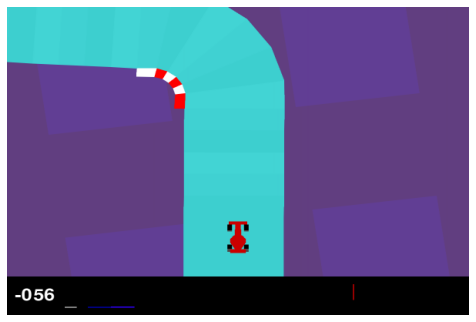

In [6]:
# Save the cartoon. We provided the generated cartoon in the /src folder.
filename = 'CarRacing-v2_random.mp4'
save_anim(frames, filename=filename)

In [7]:
# Load the best model based on evaluation. You may need to change the model 
# path depending on where your best model is stored.
model_path = "./Saved_Models/dqn_best_model_lr0001_1e7/best_model"
model = DQN.load(model_path, env=env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [10]:
# Generate observations of one episode with actions predicted by the best model.

frames = []
episodes = 1

for episode in range(1, episodes+1):
    observation, _ = env.reset()
    terminated = truncated = False
    score = 0
    
    while not (terminated or truncated):
        frames.append(env.render())
        action , _ = model.predict(observation) 
        observation, reward, terminated, truncated, info = env.step(action)
        score += reward
    print("Episode:{} Score:{}".format(episode,score))
env.close()

Episode:1 Score:917.1999999999867


In [ ]:
# Display the cartoon inline. This agent takes random actions.
# Due to the size of the video is too large, we removed the output.
# You can refer to the 'src' folder to see the generated video
# saved with the step listed below.
HTML(display_anim(frames))

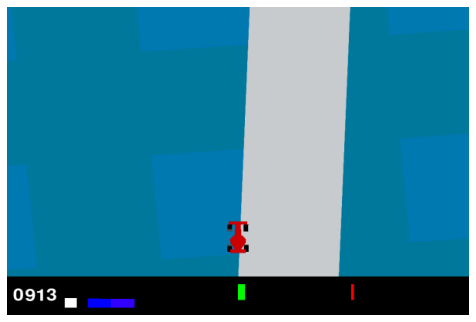

In [12]:
# Save the cartoon. We provided the generated cartoon in the /src folder.
filename = 'CarRacing-v2_best.mp4'
save_anim(frames, filename=filename)

### CPU vs GPU performance comparison

Given their capacity for parallel processing in the training of deep learning models, GPUs typically outperform CPUs significantly in this domain. In the code block below, we illustrate that AMD GPUs can be several times faster than CPUs. The specific numerical differences may vary depending on the models of hardware you are utilizing.

In [1]:
import time
from stable_baselines3 import DQN
import gymnasium as gym

env = gym.make("CarRacing-v2", domain_randomize=True,continuous=False)
env.reset(seed=1234)
env.action_space.seed(123)
t1 = time.time()
model = DQN("CnnPolicy", env, verbose=0, device="cuda")
model.learn(total_timesteps=100000)
print(f"Time with gpu : {time.time()-t1:.2f}s")

env.reset(seed=1234)
env.action_space.seed(123)
t1 = time.time()
model = DQN("CnnPolicy", env, verbose=0, device="cpu")
model.learn(total_timesteps=100000)
print(f"Time with cpu : {time.time()-t1:.2f}s")

env.close()

Time with gpu : 652.19s
Time with cpu : 5837.96s


## Acknowledgement


We express gratitude to the authors of [this notebook](https://www.kaggle.com/code/manthanbhagat/car-racing-stable-baselines/notebook), whose work serves as a valuable reference for our blog.